In [1]:
import numpy as np # linear algebra
import pandas as pd # Pemrosesan data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#/content/drive/MyDrive/Kuliah Online/Semester 7/Pembelajaran Mesin/Tugas/training.1600000.processed.noemoticon.csv

Mounted at /content/drive


**Importing Libraries and Packages**

In [3]:
# Import library use for sentiment analysis
import nltk
from nltk.corpus import stopwords
import re
import joblib
from keras.preprocessing.text import Tokenizer
import gensim
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

In [4]:
# Reading data from csv file, using latin 1 encoding with no header
df = pd.read_csv("/content/drive/MyDrive/Kuliah Online/Semester 7/Pembelajaran Mesin/Tugas/training.1600000.processed.noemoticon.csv",encoding='latin-1',header=None)

In [5]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
# Tag specific columns from dataset
columns=['target','ids','date','flag','user','text']
df.columns=columns

In [7]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
# Replacing target Values by Positive,Negative and Neutral
df.target.replace({0:'Negative',2:'Neutral',4:'Positive'},inplace=True)

In [9]:
df.head()

,target,ids,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
# Pemrosesan data
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
stop_words.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Proses data corpus
corpus=[]
for i in range(0,len(df)):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',df['text'][i])
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    review=' '.join(review)
    corpus.append(review)

In [12]:
#Replacing the text column with preprocessed text
df.text=corpus

In [13]:
df.head()

,target,ids,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,not behaving mad see


In [14]:
# Splitting the Data into Training and Test set
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(df,test_size=0.20,random_state=123)

In [15]:
train_df.head()

,target,ids,date,flag,user,text
1578903,Positive,2189875205,Tue Jun 16 01:08:25 PDT 2009,NO_QUERY,silent_serenade,withholding information shae yup
51568,Negative,1679002293,Sat May 02 08:17:21 PDT 2009,NO_QUERY,tommytrc,uhhh ummmmm yes dear keep coming tweetups prom...
569210,Negative,2207868145,Wed Jun 17 08:29:12 PDT 2009,NO_QUERY,nikkikikicoco,amazing time wannqa come home come back suitca...
71896,Negative,1694083746,Mon May 04 01:00:43 PDT 2009,NO_QUERY,bszafko,ouch wrist hurts gym accident see surgeon
405089,Negative,2058584282,Sat Jun 06 15:13:45 PDT 2009,NO_QUERY,carolduff,going crazy work school


In [16]:
test_df.head()

,target,ids,date,flag,user,text
448282,Negative,2068921155,Sun Jun 07 14:56:42 PDT 2009,NO_QUERY,smiley_sophie,arm still hurts pulled yesterday
1475261,Positive,2065871668,Sun Jun 07 09:27:21 PDT 2009,NO_QUERY,ImmaChocoholic,much outside looking 4 years w energy totally ...
132529,Negative,1835774749,Mon May 18 06:43:27 PDT 2009,NO_QUERY,drmomentum,yes knew clusterfark way since right phd annou...
182348,Negative,1967121891,Fri May 29 19:00:46 PDT 2009,NO_QUERY,sweetsheilx,woke feel relieved haha go work 2 hours
907614,Positive,1695846172,Mon May 04 07:04:29 PDT 2009,NO_QUERY,monmariej,loving hot weather forecast rest week summer a...


In [17]:
# Split text to document variable
documents = [text.split() for text in train_df.text]

In [18]:
# Word2vec Model
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [19]:
# Build a vocab from build model word2vec
w2v_model.build_vocab(documents)

In [20]:
# Convert index to key from word2vec model
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30446


In [21]:
# Train data with word2vec model
w2v_model.train(documents, total_examples=len(documents), epochs=30)

(248020594, 279410310)

In [22]:
w2v_model.wv.most_similar("good")

[('great', 0.6852174997329712),
 ('goood', 0.5779204368591309),
 ('bad', 0.5624665021896362),
 ('gooooood', 0.49757838249206543),
 ('gooood', 0.49405282735824585),
 ('nice', 0.4767811596393585),
 ('gd', 0.4659407138824463),
 ('goooood', 0.4610612094402313),
 ('fantastic', 0.44739729166030884),
 ('interesting', 0.4455053508281708)]

In [23]:
w2v_model.wv.most_similar("hate")

[('hates', 0.5527914762496948),
 ('sucks', 0.5014589428901672),
 ('stupid', 0.467989981174469),
 ('suck', 0.4668042063713074),
 ('dislike', 0.44975510239601135),
 ('h8', 0.4399300813674927),
 ('hating', 0.4228116571903229),
 ('annoying', 0.420108437538147),
 ('ugh', 0.40844041109085083),
 ('despise', 0.4016832113265991)]

In [24]:
w2v_model.wv.most_similar("great")

[('fantastic', 0.7366207838058472),
 ('wonderful', 0.7070884108543396),
 ('good', 0.6852174997329712),
 ('awesome', 0.6795097589492798),
 ('fabulous', 0.6463404297828674),
 ('amazing', 0.6361343860626221),
 ('fab', 0.6241183280944824),
 ('nice', 0.584405243396759),
 ('gr8', 0.5783430337905884),
 ('terrific', 0.5709412097930908)]

In [25]:
# Tokenizing process from dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df.text)

In [26]:
# show word index
tokenizer.word_index

{'not': 1,
 'good': 2,
 'day': 3,
 'get': 4,
 'like': 5,
 'go': 6,
 'quot': 7,
 'today': 8,
 'work': 9,
 'love': 10,
 'going': 11,
 'got': 12,
 'lol': 13,
 'time': 14,
 'back': 15,
 'u': 16,
 'one': 17,
 'know': 18,
 'im': 19,
 'really': 20,
 'amp': 21,
 'see': 22,
 'night': 23,
 'still': 24,
 '2': 25,
 'well': 26,
 'want': 27,
 'new': 28,
 'think': 29,
 'home': 30,
 'thanks': 31,
 'oh': 32,
 'much': 33,
 'miss': 34,
 'need': 35,
 'last': 36,
 'morning': 37,
 'tomorrow': 38,
 'hope': 39,
 'great': 40,
 'twitter': 41,
 '3': 42,
 'haha': 43,
 'feel': 44,
 'sad': 45,
 'fun': 46,
 'wish': 47,
 'sleep': 48,
 'right': 49,
 'would': 50,
 'bad': 51,
 'happy': 52,
 'sorry': 53,
 'tonight': 54,
 'come': 55,
 'make': 56,
 'way': 57,
 'getting': 58,
 'though': 59,
 'gonna': 60,
 'nice': 61,
 'better': 62,
 'watching': 63,
 'yeah': 64,
 'wait': 65,
 'bed': 66,
 'could': 67,
 'week': 68,
 'school': 69,
 'people': 70,
 'hate': 71,
 'days': 72,
 'even': 73,
 'hey': 74,
 'next': 75,
 '4': 76,
 'yes': 7

In [27]:
# Count vocab size from tokenizing word index
vocab_size=len(tokenizer.word_index)+1
vocab_size

290653

In [28]:
# train x variable
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen=300)
X_train

array([[    0,     0,     0, ...,  3008, 21821,   796],
       [    0,     0,     0, ...,     7,   531,  2976],
       [    0,     0,     0, ...,  9856,   874,   109],
       ...,
       [    0,     0,     0, ...,   262,   774,     1],
       [    0,     0,     0, ...,   158, 17570,    11],
       [    0,     0,     0, ...,     7, 32054,     7]], dtype=int32)

In [29]:
# test from x variable
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen=300)
X_test

array([[    0,     0,     0, ...,   256,  1664,   199],
       [    0,     0,     0, ...,  6190,  1790,    75],
       [    0,     0,     0, ...,  4779,   806,   111],
       ...,
       [    0,     0,     0, ...,   572, 66636,  1913],
       [    0,     0,     0, ...,   471,    82,   198],
       [    0,     0,     0, ...,   203,   337,  5137]], dtype=int32)

In [30]:
# train y variable
y_train=train_df.target
y_train.head()

1578903    Positive
51568      Negative
569210     Negative
71896      Negative
405089     Negative
Name: target, dtype: object

In [31]:
# test y variable
y_test=test_df.target
y_test.head()

448282     Negative
1475261    Positive
132529     Negative
182348     Negative
907614     Positive
Name: target, dtype: object

In [32]:
# Melakukan encoding kategori menjadi 0 dan 1
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test=labelencoder.fit_transform(y_test)

In [33]:
y_train.shape

(1280000,)

In [34]:
y_test.shape

(320000,)

In [35]:
# Embedding Matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290653, 300)


In [36]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [37]:
# Build lstm model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87195900  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,356,401
Trainable params: 160,501
Non-trainable params: 87,195,900
_________________________________________________________________


In [38]:
# Proses kompilasi pada model
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

**Fitting the Model**

In [39]:
model_history=model.fit(X_train, y_train,batch_size=1024,epochs=15,validation_split=0.1,verbose=1)

Epoch 1/15
1125/1125 [==============================] - 629s 556ms/step - loss: 0.4965 - accuracy: 0.7556 - val_loss: 0.4548 - val_accuracy: 0.7853
Epoch 2/15
1125/1125 [==============================] - 596s 530ms/step - loss: 0.4689 - accuracy: 0.7743 - val_loss: 0.4467 - val_accuracy: 0.7902
Epoch 3/15
1125/1125 [==============================] - 598s 531ms/step - loss: 0.4614 - accuracy: 0.7786 - val_loss: 0.4410 - val_accuracy: 0.7930
Epoch 4/15
1125/1125 [==============================] - 587s 522ms/step - loss: 0.4572 - accuracy: 0.7817 - val_loss: 0.4376 - val_accuracy: 0.7959
Epoch 5/15
1125/1125 [==============================] - 587s 522ms/step - loss: 0.4545 - accuracy: 0.7832 - val_loss: 0.4353 - val_accuracy: 0.7964
Epoch 6/15
1125/1125 [==============================] - 583s 518ms/step - loss: 0.4528 - accuracy: 0.7841 - val_loss: 0.4333 - val_accuracy: 0.7972
Epoch 7/15
1125/1125 [==============================] - 582s 517ms/step - loss: 0.4515 - accuracy: 0.7847 - val_

In [40]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Training and Validation Accuracy')

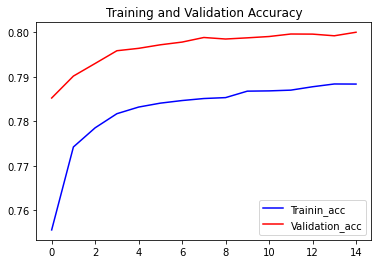

In [41]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

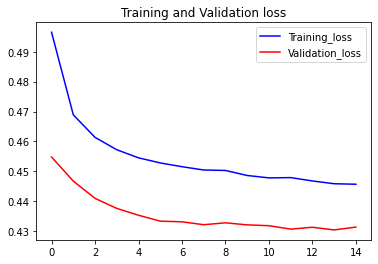

In [42]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

**Preprocessing of tweets given by user**

In [43]:
def preprocess(text):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',text)
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    print(review)
    review=pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=300)
    return review

**Prediction**

In [44]:
def prediction(review):
    review=preprocess(review)
    score=model.predict(review)
    score=score[0]
    if score<0.4:
        print("Negative")
    elif score>0.4 and score<0.6:
        print("Neutral")
    else:
        print("Positive")
    print(score)


In [45]:
prediction("the food is not bad")

['food', 'not', 'bad']
Positive
[0.729192]


In [46]:
prediction("the film was horrible")

['film', 'horrible']
Negative
[0.09077048]


In [47]:
scores = model.predict(X_test, verbose=1, batch_size=1024)

313/313 [==============================] - 33s 104ms/step


In [ ]:
scores

In [ ]:
y_pred=np.where(scores>0.5,1,0)

In [ ]:
y_pred

In [ ]:
y_test

**Evaluation Using Confusion Matrix, accuracy_score and classification report**

In [ ]:

cm=confusion_matrix(y_pred,y_test)
print(cm)

In [ ]:
print(accuracy_score(y_pred,y_test))

In [ ]:
print(classification_report(y_test, y_pred))

**Saving the Trained Models**

In [55]:
joblib.dump(w2v_model,'word2vec.pkl')
joblib.dump(tokenizer,'tokenizer.pkl')
joblib.dump(model,'final_model.pkl')

INFO:tensorflow:Assets written to: ram://8b81186c-3fff-4a87-9379-d566ed741435/assets


['final_model.pkl']